In [83]:
import os
import re
import json
import numpy as np
import pandas as pd
from textwrap import wrap
from openai import OpenAI
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm import tqdm
from sklearn.metrics import jaccard_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

metrics = {
	"jaccard_score" : jaccard_score, 
	"recall_score" : recall_score, 
	"precision_score" : precision_score, 
	"f1_score" : f1_score, 
	"accuracy_score" : accuracy_score
}

# Create new `pandas` methods which use `tqdm` progress
tqdm.pandas()

# Analyze full 3.5 and 4.0 predictions:

In [84]:
df = pd.read_csv("cleaned_full_dataset.csv")
df.head(3)

,comments,who,review_star_rating,sch_name,sch_state,sch_county,sch_type,nlp_school-level features,nlp_physical environment,nlp_instruction & learning,...,3.5_resources,3.5_output,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources,4_output
0,(PLEASE DONOT SEND YOUR KIDS HERE) LOTS OF BUL...,parent,1.0,Albertville Middle School,AL,MARSHALL COUNTY,tps,1,1,0,...,0.0,"['schoollevel features: 0', 'physical environm...",0.0,0.0,1.0,1.0,1.0,1.0,0.0,"['schoollevel features: 0', 'physical environm..."
1,I attended Albertville High School my freshman...,student,2.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,1,1,1,...,0.0,"['schoollevel features: 0', 'physical environm...",1.0,0.0,1.0,0.0,1.0,1.0,1.0,"['schoollevel features: 1', 'physical environm..."
2,My son enjoys school. I am amazed how well sch...,parent,5.0,ALBERTVILLE HIGH SCH,AL,MARSHALL COUNTY,tps,0,0,0,...,0.0,"['schoollevel features: 0', 'physical environm...",1.0,1.0,0.0,1.0,1.0,1.0,0.0,"['schoollevel features: 1', 'physical environm..."


In [70]:
categories = ['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

# ChatGPT 3.5 Predictions

In [74]:
full_predictions_35 = df[["3.5_"+category for category in categories]].astype(int)
full_predictions_35

,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources
0,0,0,1,1,1,0,0
1,0,0,1,0,0,1,0
2,0,1,1,1,1,1,0
3,0,0,1,1,1,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
492,0,0,1,1,1,1,0
493,1,0,1,1,1,1,1
494,0,1,0,1,1,0,0
495,1,0,1,0,1,1,1


In [73]:
coded_data = df[categories]
coded_data

,school-level features,physical environment,instruction & learning,school staff,overall quality,school culture,resources
0,0,1,1,1,1,0,1
1,0,0,1,1,1,0,1
2,0,0,0,0,1,1,0
3,0,1,0,1,1,1,0
4,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...
492,0,0,1,1,1,0,1
493,0,0,0,1,1,1,0
494,0,1,1,1,0,0,0
495,0,0,0,1,1,0,0


school-level features
	Coded total positive: 199  | 3.5 GPT total positive 195
	Coded total negative: 298  | 3.5 GPT total negative 302
	Coded total total: 497  | 3.5 GPT total total 497
physical environment
	Coded total positive: 167  | 3.5 GPT total positive 73
	Coded total negative: 330  | 3.5 GPT total negative 424
	Coded total total: 497  | 3.5 GPT total total 497
instruction & learning
	Coded total positive: 330  | 3.5 GPT total positive 343
	Coded total negative: 167  | 3.5 GPT total negative 154
	Coded total total: 497  | 3.5 GPT total total 497
school staff
	Coded total positive: 402  | 3.5 GPT total positive 427
	Coded total negative: 95  | 3.5 GPT total negative 70
	Coded total total: 497  | 3.5 GPT total total 497
overall quality
	Coded total positive: 428  | 3.5 GPT total positive 398
	Coded total negative: 69  | 3.5 GPT total negative 99
	Coded total total: 497  | 3.5 GPT total total 497
school culture
	Coded total positive: 351  | 3.5 GPT total positive 364
	Coded total 

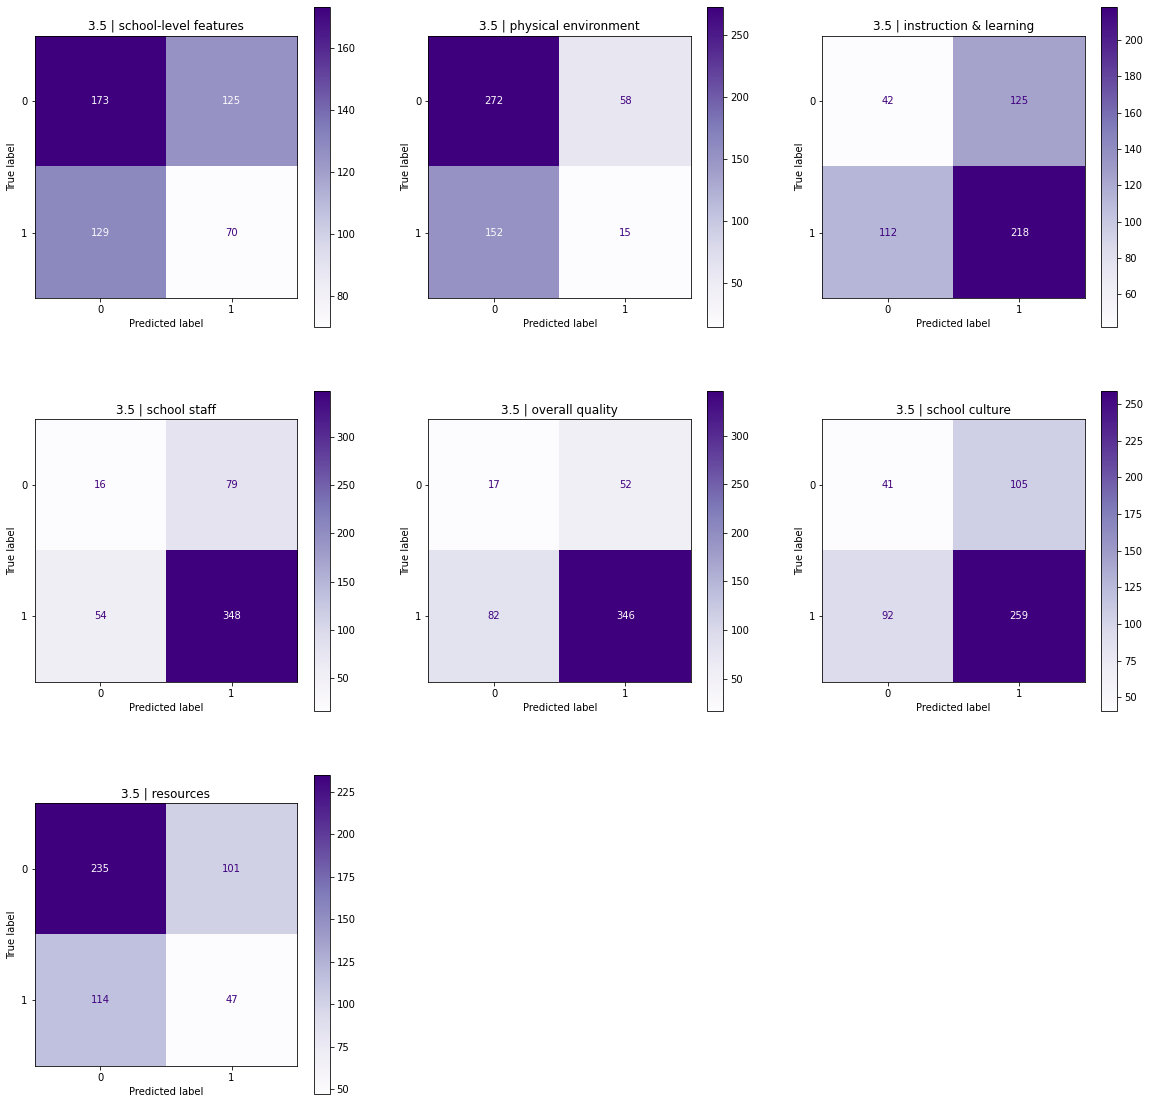

In [93]:

fig, axs = plt.subplots(figsize=(20, 20), ncols=3,nrows=3)
axs.ravel()[-1].remove()
axs.ravel()[-2].remove()
# print(prompt)
for ax, category in zip(axs.ravel(), categories):
	# print("\t",category)
	category_prediction = full_predictions_35["3.5_"+category].astype(int)
	coded_prediction = coded_data[category].astype(int)
	
	matrix = confusion_matrix(coded_prediction, category_prediction)
	tn, fp, fn, tp = matrix.ravel()
	print(category)
	print("\tCoded total positive:", tp+fn, " | 3.5 GPT total positive", tp+fp)
	print("\tCoded total negative:", tn+fp, " | 3.5 GPT total negative", tn+fn)
	print("\tCoded total total:", tn+fp+fn+tp, " | 3.5 GPT total total", tn+fp+fn+tp)
	ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap="Purples", ax=ax)
	ax.set_title(f"3.5 | {category}")
	
	# for name, metric in metrics.items():
	# 	print("\t\t",name, ":", metric(coded_prediction, category_prediction))
		

## 3.5 Analysis:

It seems that 3.5 struggles with some of the more abstract category names like school-level features, physical environment, and resources. 
- All of these categories both have relatively high levels of false-positives and false negatives
- The model tends to categorize more negatively than positively, which is a pattern shared by the human coders

It seems to do well with school staff, overall quality, and school culture, all of which are very highly positively categorized by coders and are pretty straigthforward concept wise. 



# ChatGPT 4.0 Predictions

In [88]:
full_predictions_40 = df[["4_"+category for category in categories]].astype(int)
full_predictions_40

,4_school-level features,4_physical environment,4_instruction & learning,4_school staff,4_overall quality,4_school culture,4_resources
0,0,0,1,1,1,1,0
1,1,0,1,0,1,1,1
2,1,1,0,1,1,1,0
3,1,0,1,1,0,1,0
4,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...
492,1,0,1,1,1,1,0
493,1,0,1,1,1,1,1
494,1,0,1,1,1,1,1
495,1,1,1,0,1,1,1


school-level features
	Total positive: 199
	Total negative: 298
	Total total: 497
physical environment
	Total positive: 167
	Total negative: 330
	Total total: 497
instruction & learning
	Total positive: 330
	Total negative: 167
	Total total: 497
school staff
	Total positive: 402
	Total negative: 95
	Total total: 497
overall quality
	Total positive: 428
	Total negative: 69
	Total total: 497
school culture
	Total positive: 351
	Total negative: 146
	Total total: 497
resources
	Total positive: 161
	Total negative: 336
	Total total: 497


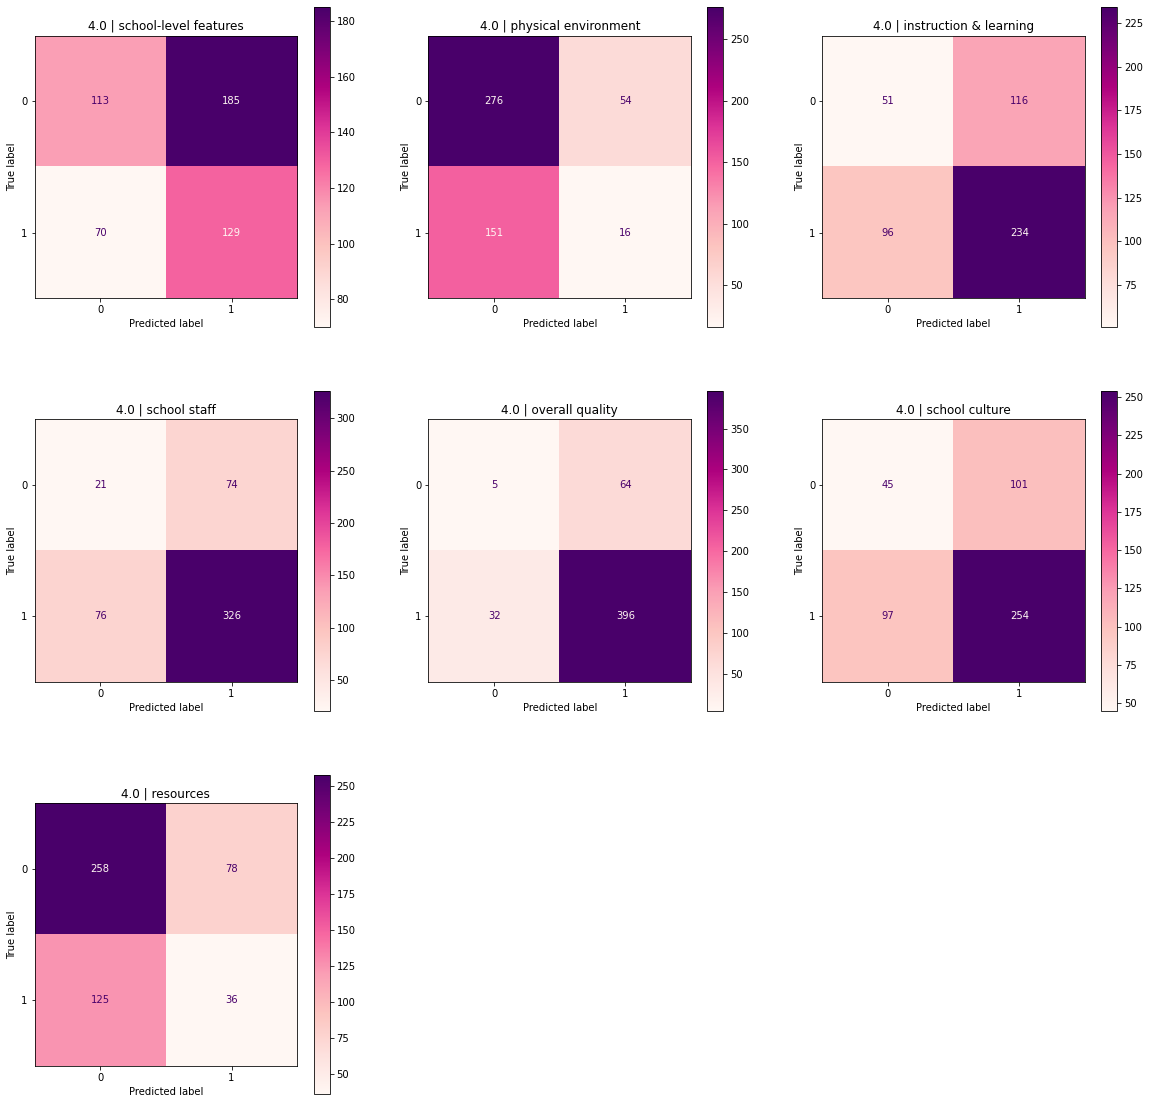

In [92]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=3,nrows=3)
axs.ravel()[-1].remove()
axs.ravel()[-2].remove()
# print(prompt)
for ax, category in zip(axs.ravel(), categories):
	# print("\t",category)
	category_prediction = full_predictions_40["4_"+category].astype(int)
	coded_prediction = coded_data[category].astype(int)
	
	matrix = confusion_matrix(coded_prediction, category_prediction)
	tn, fp, fn, tp = matrix.ravel()
	print(category)
	print("\tCoded total positive:", tp+fn, " | 4.0 GPT total positive", tp+fp)
	print("\tCoded total negative:", tn+fp, " | 4.0 GPT total negative", tn+fn)
	print("\tCoded total total:", tn+fp+fn+tp, " | 4.0 GPT total total", tn+fp+fn+tp)
	ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap="RdPu", ax=ax)
	ax.set_title(f"4.0 | {category}")
	
	# for name, metric in metrics.items():
	# 	print("\t\t",name, ":", metric(coded_prediction, category_prediction))
		

## 4.0 Analysis:

Strangely, 4.0 seems to exhibit very different behavior from 3.5.


It seems that 3.5 struggles with some of the more abstract category names like school-level features, physical environment, and resources. 
- All of these categories both have relatively high levels of false-positives and false negatives
- The model tends to categorize more negatively than positively, which is a pattern shared by the human coders

It seems to do well with school staff, overall quality, and school culture, all of which are very highly positively categorized by coders and are pretty straigthforward concept wise. 



In [125]:
cmaps = {
	"Coded" : "Purples",
	"3.5" : "Oranges",
	"4.0" : "YlGn"
}

def get_comparison_category(category):
	fig, axs = plt.subplots(figsize=(20, 5), ncols=3,nrows=1)
	axs = axs.ravel()
	ax_index = 0
	category_prediction_45 = full_predictions_40["4_"+category].astype(int)
	category_prediction_35 = full_predictions_35["3.5_"+category].astype(int)
	coded_prediction = coded_data[category].astype(int)
	
	for name, prediction in {"Coded":coded_prediction, "3.5":category_prediction_35, "4.0":category_prediction_45}.items():
		ax = axs[ax_index]
		ax_index+=1
		
		matrix = confusion_matrix(coded_prediction, prediction) #, normalize="all")
		tn, fp, fn, tp = matrix.ravel()
		ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap=cmaps[name], ax=ax)
		ax.set_title(f"{name} | {category}")
		

In [123]:
categories

['school-level features',
 'physical environment',
 'instruction & learning',
 'school staff',
 'overall quality',
 'school culture',
 'resources']

## School-Level Features

- We can see that the coded reviewers negatively label school-level features (they don't label them positive as often as they do negatively).
- This trend is evident in 3.5's predictions, which do tend to be negative. 
- However the 4.0 model leans the opposite direction, whether this is due to a higher or lower comprehension of the category is unclear. 
- Both GPTs suffer in this category with higher false negative and false positives, this could be because of the abstract nature of the category.

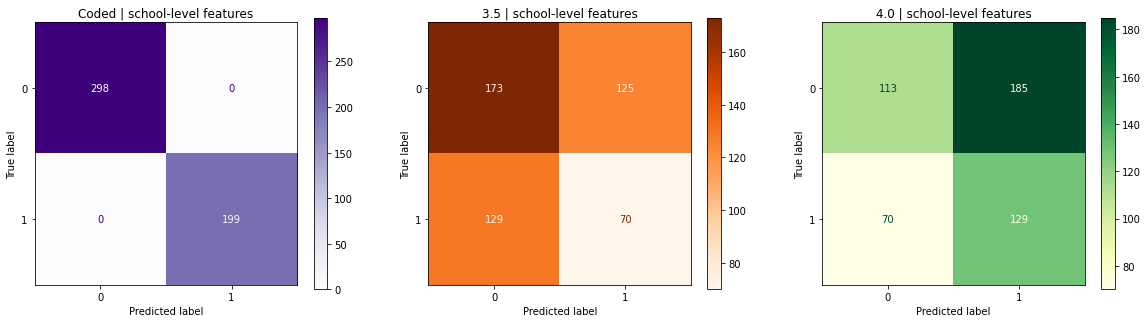

In [124]:
get_comparison_category('school-level features')

## Physical Environment

- The coded reviews also lean negatively here
- 3.5 and 4.0 are on the same track and tend to label negatively, though there are a fair number of false positives.
- The high number of false positives is a trend, GPTs seem to focus more on precision rather than recall without guidance which is interesting

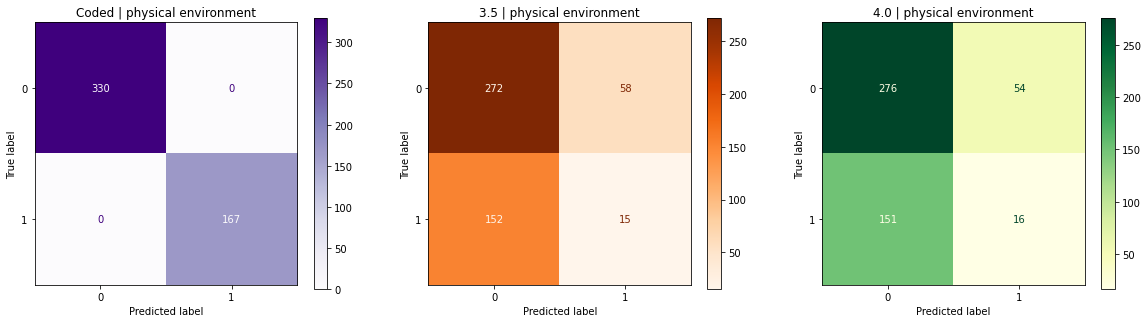

In [126]:
get_comparison_category('physical environment')

## Instruction & Learning
- The coders tend to label this category positively
- Both GPTs tend to label positively as well
- There is a fairly even spread between false positives and false negatives
- While the models like to annotate this positively they also seem to be a bit all over the place compared to the coders

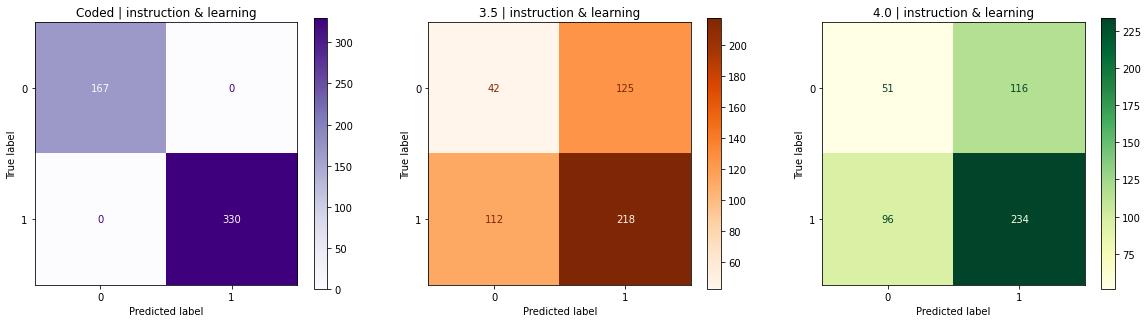

In [127]:
get_comparison_category('instruction & learning')

## School Staff

- The coders annotate overwhelmingly positively, with 20% being labeled negatively for this class
- This makes sense considering school staff are probably more discussed than school level features or some of our other categories
- Both GPTs knock it out of the park with this one, mostly positives
- The false positives and false negatives are again spread evenly
- This indicates that this category is a little easier to comprehend and understand from context

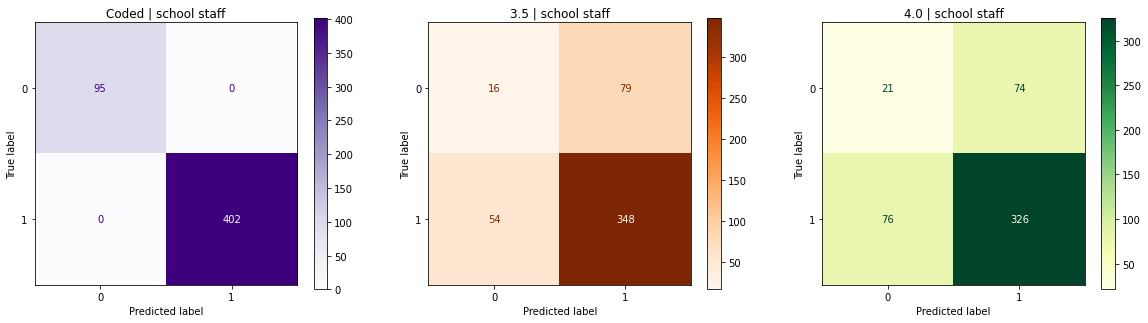

In [128]:
get_comparison_category('school staff')

## Overall Quality

- This is similar to school staff, overall quality could arguably be applied to most reviews
- same spread for both GPTs

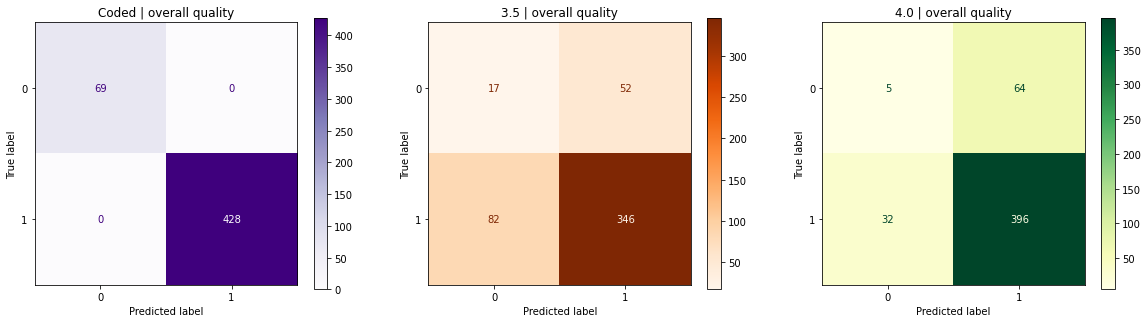

In [129]:
get_comparison_category('overall quality')

## School culture

- As a more abstract concept there is a bit more division, but coders lean towards positives here
- 3.5 and 4.0 both lean positively but have a fair spread of false negatives and positives like with overall quality and instruction and learning
- This is likely a harder concept to understand compared to overall quality but still comprehensible enough for ChatGPT to get the idea

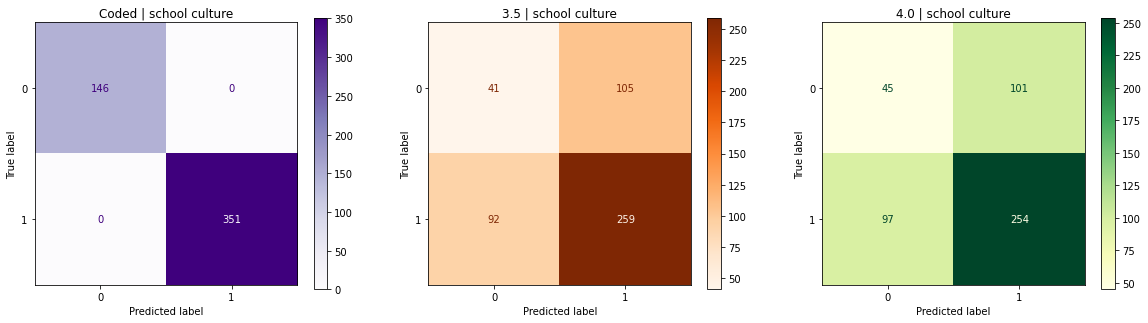

In [130]:
get_comparison_category('school culture')

## Resources

- Coders tend to label this negatively
- Both GPTs lean negatively with an even spread of false positives and false negatives as in the other categories

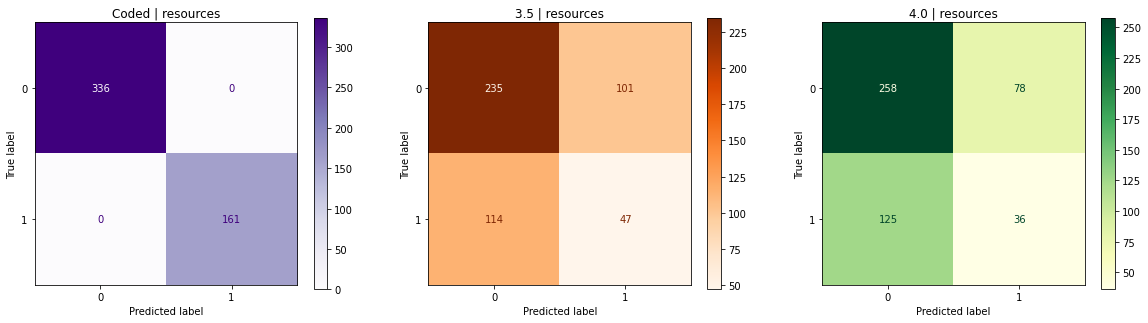

In [131]:
get_comparison_category('resources')

# Final conclusions

Using GPTs to label data introduces a slew of technical and logical challenges which are vastly different from the usual issues in the field of NLP. In this context, the biggest issue becomes one of interpretability. ChatGPT responds to textual data much like a human would, and in a way is well-suited for this task. Comparing the results of these models against coders results in accuracies that are less than a boilerplate "NLP" model, but that is if the source of truth is human- an arbitrary metric.

Arguably if the same group of coders were to re-code these same reviews, the results would differ substantially from the original coding, perhaps by more than a GPT. 

Efficacy aside, the results of this experiment are twofold: 
- ChatGPT can be used to annotate data with reasonable accuracy
- How comprehensible a category is does seem to impact how well it is encoded (similarly to how humans label)


# Get new predictions with prompt modifications:


In [19]:
from importlib import reload # python 2.7 does not require this
import get_gpt_predictions
reload( get_gpt_predictions )
from get_gpt_predictions import predict_table

predictions_35 = predict_table(categories, df.iloc[:10]["comments"])
predictions_35

Querying ChatGPT for categorization predictions


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,0,1,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,0,0,"[schoollevel features: 0, physical environment..."
2,0,1,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
3,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
4,0,0,0,0,0,1,0,"[schoollevel features: 0, physical environment..."
5,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
6,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
7,0,0,1,1,1,1,1,"[schoollevel features: 0, physical environment..."
8,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
9,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."


In [49]:
prompts = {
	"Original Prompt": "Which of these topics: {}\n\nAre discussed in this review: \"{}\". For all topics, respond in the format: \"topic\": 0 or 1.",
	
	# Attempting to maximize recall
	"Recall penalization prompt": "Which of these topics: {}\n\nAre discussed in this review: \"{}\". For all topics, respond in the format: \"topic\": 0 or 1. You will be penalized for every topic you miss.",
	
	# Attempting to maximize precision
	"Precision penalization prompt": "Which of these topics: {}\n\nAre discussed in this review: \"{}\". For all topics, respond in the format: \"topic\": 0 or 1. You will be penalized for every topic you count that isn't in the review.",
	
	# Attempting to emphasize the importance of the task and maximize accuracy
	"Exaggerated prompt": "Which of these topics: {}\n\nAre discussed in this review: \"{}\". For all topics, respond in the format: \"topic\": 0 or 1. Be as accurate as possible, make sure that every topic in the review is correctly labeled, you will be penalized for every mislabeled topic. ."
}

dataframes = {}

for prompt_name, prompt in prompts.items():
	dataframes[prompt_name] = predict_table(categories, df[:10]["comments"], query=prompt, log=prompt_name)
	
dataframes.keys()

Querying ChatGPT for categorization predictions | Original Prompt


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Querying ChatGPT for categorization predictions | Recall penalization prompt


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Querying ChatGPT for categorization predictions | Precision penalization prompt


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Querying ChatGPT for categorization predictions | Exaggerated prompt


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


dict_keys(['Original Prompt', 'Recall penalization prompt', 'Precision penalization prompt', 'Exaggerated prompt'])

In [50]:
for dataframe in dataframes.values():
	display(dataframe.head(5))

,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,0,1,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,1,0,"[schoollevel features: 0, physical environment..."
2,0,1,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
3,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
4,0,0,0,0,0,0,0,"[schoollevel features: 0, physical environment..."


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,1,0,"[schoollevel features: 0, physical environment..."
2,0,1,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
3,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
4,0,0,0,0,0,0,0,"[schoollevel features: 0, physical environment..."


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,1,0,"[schoollevel features: 0, physical environment..."
2,0,1,0,1,1,1,0,"[schoollevel features: 0, physical environment..."
3,0,0,1,1,0,0,0,"[schoollevel features: 0, physical environment..."
4,0,0,0,1,1,1,0,"[schoollevel features: 0, physical environment..."


,3.5_school-level features,3.5_physical environment,3.5_instruction & learning,3.5_school staff,3.5_overall quality,3.5_school culture,3.5_resources,3.5_output
0,0,0,1,1,1,1,0,"[schoollevel features: 0, physical environment..."
1,0,0,1,0,0,1,0,"['schoollevel features': 0, 'physical environm..."
2,0,1,0,1,1,1,0,"['schoollevel features': 0, 'physical environm..."
3,0,0,1,1,1,0,0,"[schoollevel features: 0, physical environment..."
4,0,0,0,1,0,1,0,"[ 'schoollevel features': 0, 'physical enviro..."


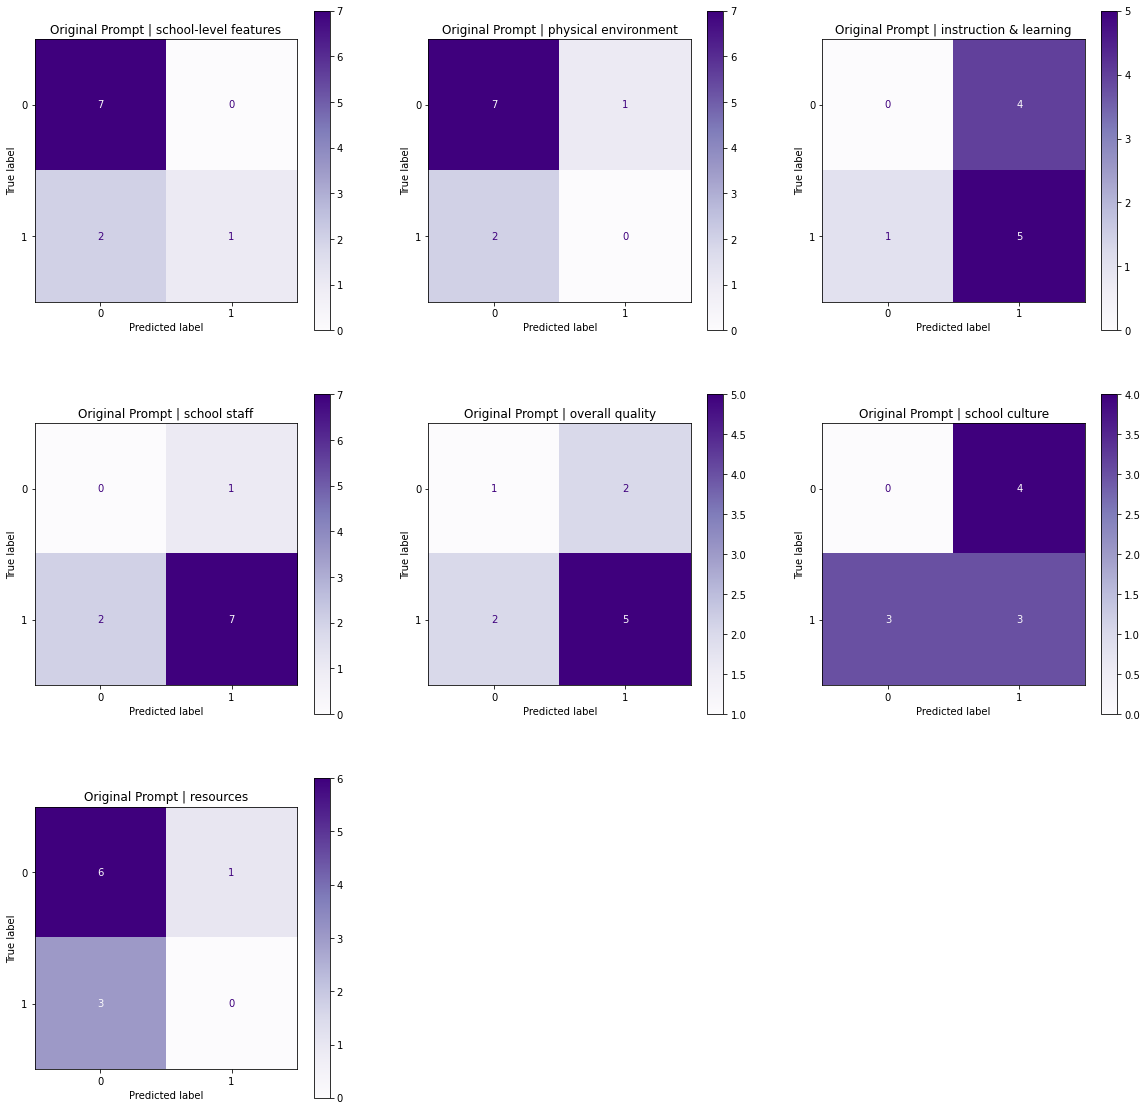

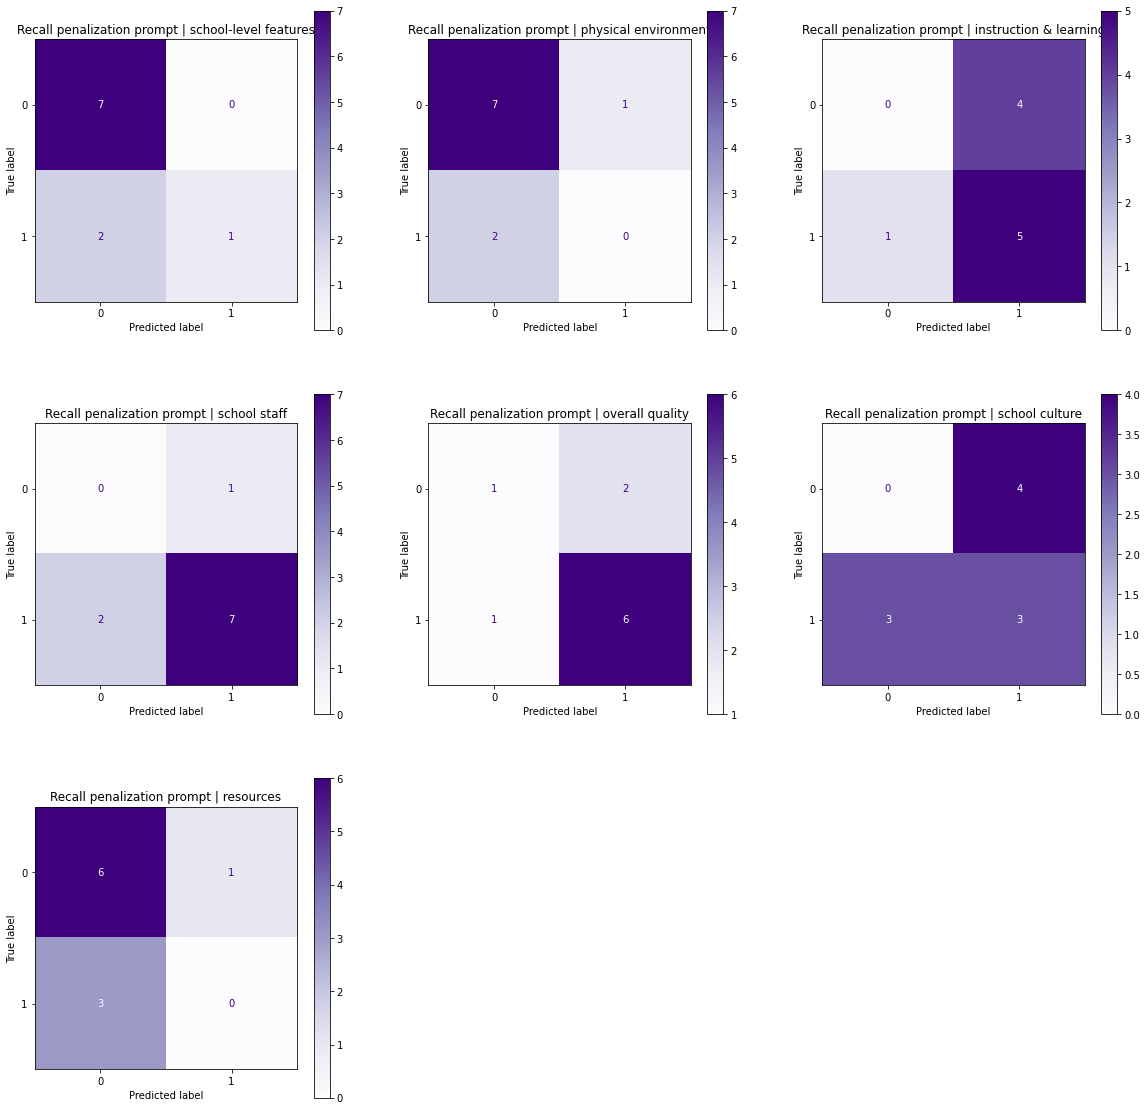

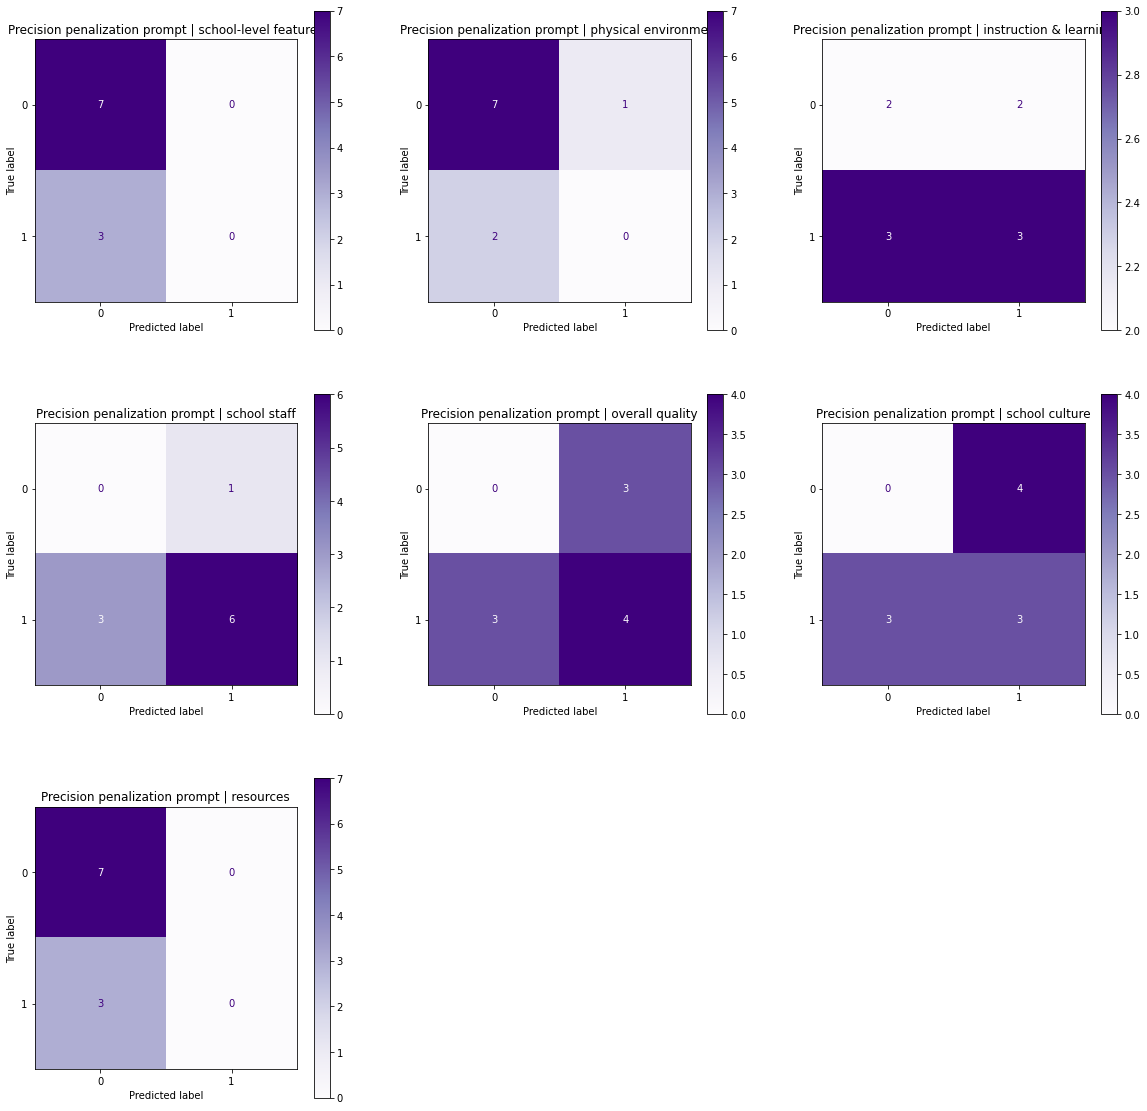

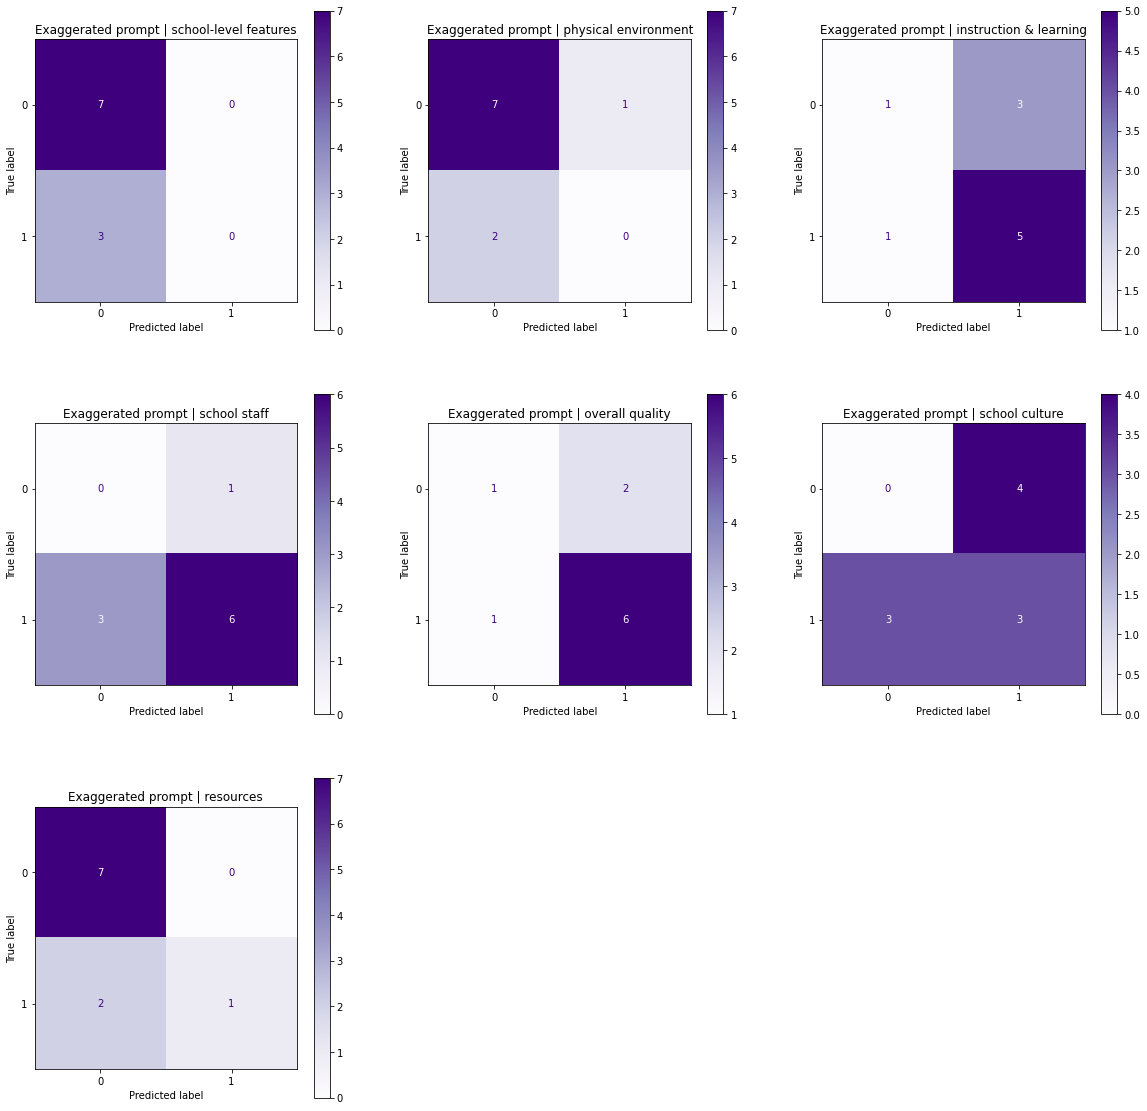

In [54]:


for prompt, dataframe in dataframes.items():
	
	fig, axs = plt.subplots(figsize=(20, 20), ncols=3,nrows=3)
	axs.ravel()[-1].remove()
	axs.ravel()[-2].remove()
	# print(prompt)
	for ax, category in zip(axs.ravel(), categories):
		# print("\t",category)
		category_prediction = dataframe["3.5_"+category].astype(int)
		coded_prediction = coded.iloc[:10][category].astype(int)
		
		matrix = confusion_matrix(coded_prediction, category_prediction)
		ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap="Purples", ax=ax)
		ax.set_title(f"{prompt} | {category}")
		
		# for name, metric in metrics.items():
		# 	print("\t\t",name, ":", metric(coded_prediction, category_prediction))
		

In [65]:
table = PrettyTable()
table.add_column("categories", categories)

for prompt, dataframe in dataframes.items():
	
	# fig, axs = plt.subplots(figsize=(20, 20), ncols=3,nrows=3)
	# axs.ravel()[-1].remove()
	# axs.ravel()[-2].remove()
	accuracies = []
	for category in categories:
		category_prediction = dataframe["3.5_"+category].astype(int)
		coded_prediction = coded.iloc[:10][category].astype(int)
		accuracies.append(accuracy_score(coded_prediction, category_prediction))
	table.add_column(prompt, accuracies)
		# matrix = confusion_matrix(coded_prediction, category_prediction)
		# ConfusionMatrixDisplay(confusion_matrix=matrix).plot(cmap="Purples", ax=ax)
		# ax.set_title(f"{prompt} | {category}")
		# print("\t\t","accuracy", ":", accuracy_score(coded_prediction, category_prediction))
		# for name, metric in metrics.items():
		# 	print("\t\t",name, ":", metric(coded_prediction, category_prediction))

print(table)
		

+------------------------+-----------------+----------------------------+-------------------------------+--------------------+
|       categories       | Original Prompt | Recall penalization prompt | Precision penalization prompt | Exaggerated prompt |
+------------------------+-----------------+----------------------------+-------------------------------+--------------------+
| school-level features  |       0.8       |            0.8             |              0.7              |        0.7         |
|  physical environment  |       0.7       |            0.7             |              0.7              |        0.7         |
| instruction & learning |       0.5       |            0.5             |              0.5              |        0.6         |
|      school staff      |       0.7       |            0.7             |              0.6              |        0.6         |
|    overall quality     |       0.6       |            0.7             |              0.4              |      